## Here we will analyze tennis first-serve data. The real data that we obtained and formatted in data_formatter.ipynb

This work is based on crowdsourced shot-by-shot professional tennis data by The Tennis Abstract Match Charting Project, and is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. Based on a work at https://github.com/JeffSackmann/tennis_MatchChartingProject

## We want to look at correlations between each service (if the first serve went in, what is the chance it goes in on the next point?).

## First things first, lets make our data structure class to hold everything. Note that this is just a copy/pasting of the functions from the mock_data analysis notebook. None of the machinery has changed, so I refer the reader to that notebook (which validates this method anyhow)

In [1]:
import json

class Data(object):
    def __init__(self, serve_data=None):
        self.serve_data = serve_data

    def __getitem__(self, player_id):
        return self.serve_data[player_id]

    @property
    def player_ids(self):
        return list(self.serve_data.keys())

    @classmethod
    def load(cls, path):
        with open(path, 'r') as file:
            serve_data = json.load(file)
        serve_data = {key: val for key, val in serve_data.items()} # get rid of the string keys.
        return cls(serve_data)

# first, lets load in the mock data:
data = Data.load('formatted_data/first_serve_fault_data.json')

Now we can easily pull each set of data for each player as follows

In [2]:
print(data['Roger Federer'][5], 'RF, game 5')
print(data['Roger Federer'][30], 'RF, game 30 (note that we combined all matches sets and games in one long string)')

[1, 1, 1, 1] RF, game 5
[1, 0, 0, 1, 1, 0, 0, 0] RF, game 30 (note that we combined all matches sets and games in one long string)


In [3]:
from astropy.table import Table
import numpy as np
import numba as nb

def list_to_tuples(a):
    """
    convert a list e.g,  [1, 0, 1, 0, 1, 1] into [[1, 0], [0, 1], [1, 0], [0, 1], [1, 1]]
    """
    return [list(i) for i in zip(a, a[1:])]

def sequence_count(array_of_sequences):
    num_1_1 = np.count_nonzero(np.all(array_of_sequences == [1, 1], axis=1))
    num_1_0 = np.count_nonzero(np.all(array_of_sequences == [1, 0], axis=1))
    num_0_1 = np.count_nonzero(np.all(array_of_sequences == [0, 1], axis=1))
    num_0_0 = np.count_nonzero(np.all(array_of_sequences == [0, 0], axis=1))
    return num_1_1, num_1_0, num_0_1, num_0_0

@nb.jit # slight speedup by compiling this first.
def sequence_count_fast(list_of_sequences):
    """
    identical in function to sequence_count(), but about 20% faster. Although also much harder to read.
    """
    num_1_1, num_1_0, num_0_1, num_0_0 = 0, 0, 0, 0
    for seq in list_of_sequences:
        if seq[0] == 1:
            if seq[1] == 1:
                num_1_1 += 1
            else: # seq[1] is 0
                num_1_0 += 1
        else: # seq[0] is 0
            if seq[1] == 1:
                num_0_1 += 1
            else: # seq[1] is 0
                num_0_0 += 1
    return num_1_1, num_1_0, num_0_1, num_0_0

def estimate_conditional_probability(player_serve_data):
    all_tuple_sequences = []
    for game in player_serve_data:
        all_tuple_sequences.extend(list_to_tuples(game))
    num_1_1, num_1_0, num_0_1, num_0_0 = sequence_count(np.array(all_tuple_sequences))
    # convert the short hand sequence notation to human readable variables
    num_good_with_good_last_serve = num_1_1
    num_good_with_bad_last_serve = num_0_1
    num_bad_with_bad_last_serve = num_0_0
    num_bad_with_good_last_serve = num_1_0
    total_lf = num_0_0 + num_0_1  # total bad serves
    total_lg = num_1_1 + num_1_0  # total good serves
    total_serves = total_lf + total_lg
    #
    # calculate the conditional probabilities from the counts.
    pglg = num_good_with_good_last_serve / total_lg
    pflg = num_bad_with_good_last_serve / total_lg
    pglf = num_good_with_bad_last_serve / total_lf
    pflf = num_bad_with_bad_last_serve / total_lf
    #print(pglg, pglf)
    pg = (num_good_with_good_last_serve + num_good_with_bad_last_serve)/ total_serves
    pf = (num_bad_with_bad_last_serve + num_bad_with_good_last_serve)/ total_serves
    # calculate the errors from simple Poisson counting statistics.
    e_pglg = np.sqrt(num_good_with_good_last_serve) / total_lg
    e_pflg = np.sqrt(num_bad_with_good_last_serve) / total_lg
    e_pglf = np.sqrt(num_good_with_bad_last_serve) / total_lf
    e_pflf = np.sqrt(num_bad_with_bad_last_serve) / total_lf
    e_pg = np.sqrt(num_good_with_good_last_serve + num_good_with_bad_last_serve)/ total_serves
    e_pf = np.sqrt(num_bad_with_bad_last_serve + num_bad_with_good_last_serve)/ total_serves 
    return {'pglg': pglg, 'pglf': pglf, 'pflg': pflg, 'pflf': pflf, 'pg': pg, 'pf': pf,
            'e_pglg': e_pglg, 'e_pglf': e_pglf, 'e_pflg': e_pflg, 'e_pflf': e_pflf, 'e_pg': e_pg, 'e_pf': e_pf}

In [4]:
# Check that probabilities sum to 1.
result = estimate_conditional_probability(data['Roger Federer'])
print(result['pg'] + result['pf'])

1.0


Quick sanity check (this would be e.g. a unit test in an actual code base, but for this 
analysis we will just run this here)
We want to check that the conditional probabilities add up as expected. 

In [5]:
result = estimate_conditional_probability(data['Roger Federer'])
print('probability of having a faulted serve, from two different estimates:')
print(result['pf'] * result['pflf'] + result['pg'] * result['pflg'])
print(result['pf'])
print('probability of having a good serve, from two different estimates:')
estimate = result['pf'] * result['pglf'] + result['pg'] * result['pglg']
print(estimate)
print(result['pg'])
print(f'indeed, these two agree within {np.abs(estimate - result["pg"])}. The counting error is: {np.round(result["e_pg"], 4)}, and so these are consistent with each other.')
print(result['pg'] + result['pf'], 'Check that P(G) + P(F) = 1.0')
print('check that Bayes theorem is obeyed: P(F|LG) = P(G|LF)*P(F)/P(G)')
print(result['pflg'], result['pglf'] * result['pf']/result['pg'])
print(result['pglf'], result['pflg'] * result['pg']/result['pf'])
print('And indeed Bayes theorem is obeyed, within the errors.')

probability of having a faulted serve, from two different estimates:
0.33042068781837997
0.3305409286740067
probability of having a good serve, from two different estimates:
0.6695793121816199
0.6694590713259932
indeed, these two agree within 0.0001202408556266743. The counting error is: 0.009, and so these are consistent with each other.
1.0 Check that P(G) + P(F) = 1.0
check that Bayes theorem is obeyed: P(F|LG) = P(G|LF)*P(F)/P(G)
0.32684966369750956 0.327029272669554
0.6623467600700526 0.6619829901244998
And indeed Bayes theorem is obeyed, within the errors.


We also want to check that in the no hot hands case, that P(F) = P(F|LF) = P(F|LG) and that P(G) = P(G|LG) = P(G|LF), because subsequent serves have no impact on each other in the hot hands case.

In [6]:
result = estimate_conditional_probability(data['Roger Federer'])
print(result['pf'])
print(result['pg'])
print('This tells us that Rogers first serve percentage is right around 67% -- which agrees roughly what the ATP has listed')

result = estimate_conditional_probability(data['John Isner'])
print(result['pf'])
print(result['pg'])
print('They all are equal for the null case (within the errors)!')
print('So we can be confident that estimate_conditional_probability() is working properly')
print('Moreover, this tells us that Rogers first serve percentage is right around 73% -- which agrees roughly what the ATP has listed.')

0.3305409286740067
0.6694590713259932
This tells us that Rogers first serve percentage is right around 67% -- which agrees roughly what the ATP has listed
0.2635726795096322
0.7364273204903677
They all are equal for the null case (within the errors)!
So we can be confident that estimate_conditional_probability() is working properly
Moreover, this tells us that Rogers first serve percentage is right around 73% -- which agrees roughly what the ATP has listed.


# Now we estimate the conditional probabilities for every player.

In [7]:
from astropy.table import vstack

def estimate_conditional_probabilities_all_players(case: Data) -> Table:
    statistics = []
    for player_id in case.player_ids:
        result = estimate_conditional_probability(case[player_id])
        result['player_id'] = player_id
        statistics.append(result)
    return vstack(statistics)

fpstats = estimate_conditional_probabilities_all_players(data)

## Now lets plot P(G|LG) and P(G|LF) for every player.

<ipython-input-68-993133919153>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90) # Rotates X-Axis Ticks by 45-degrees


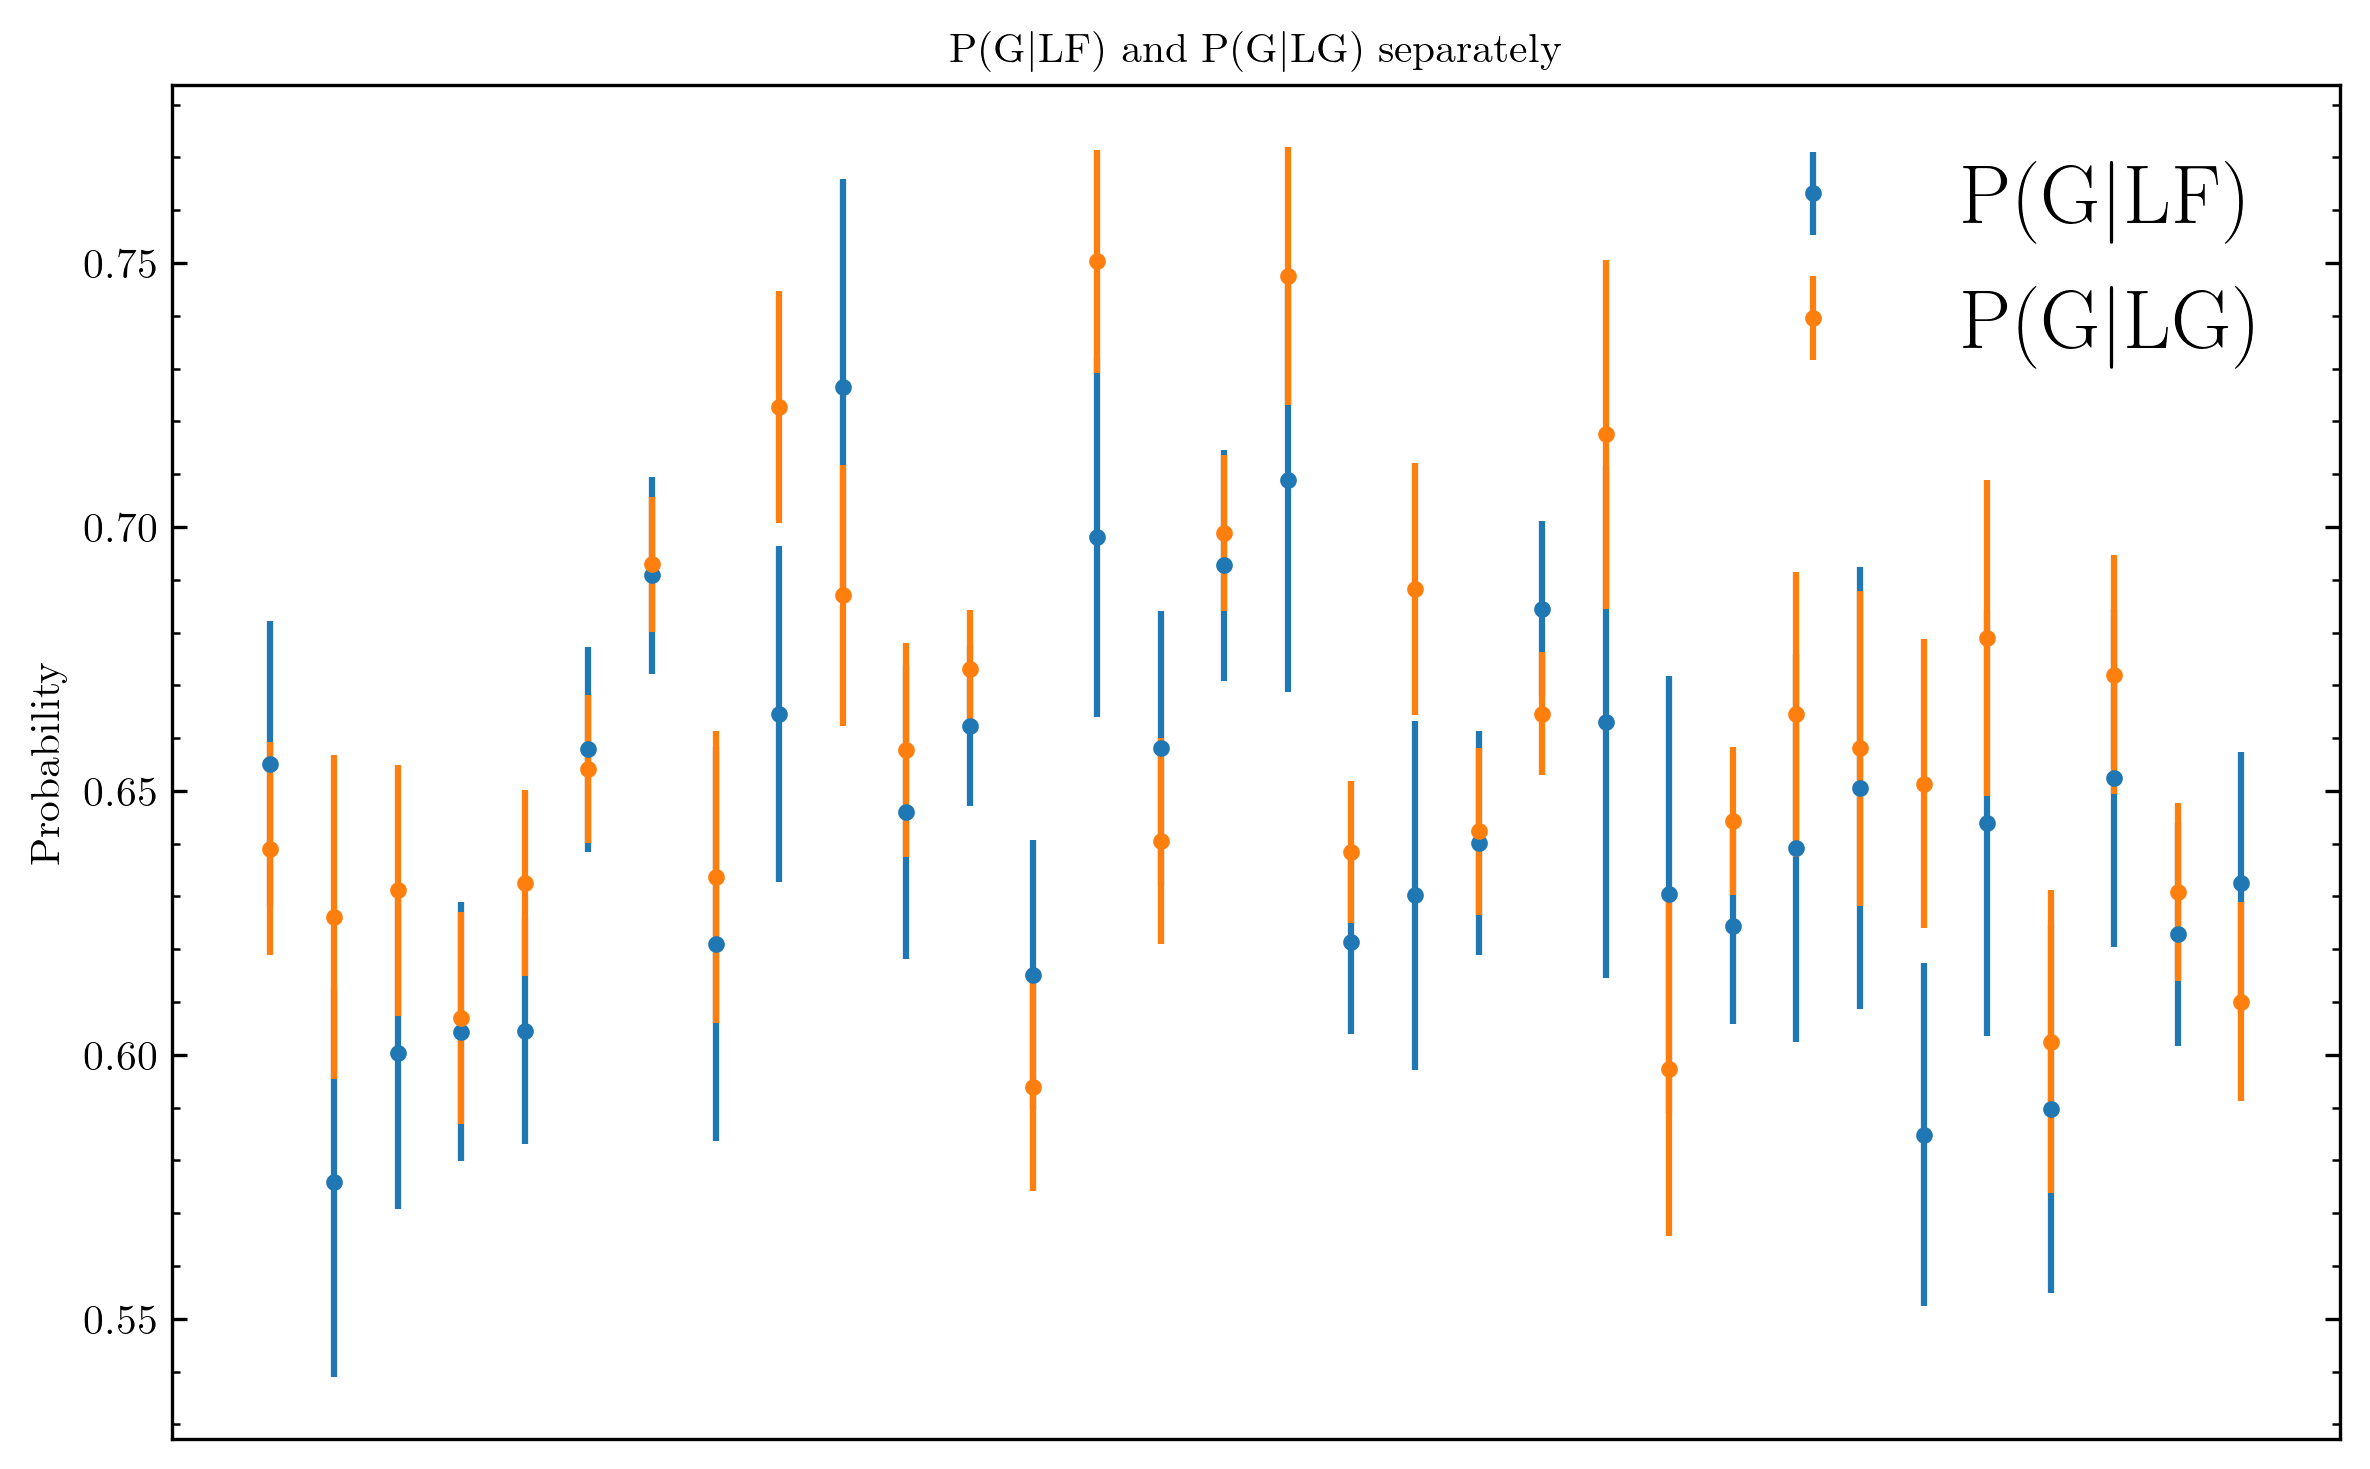

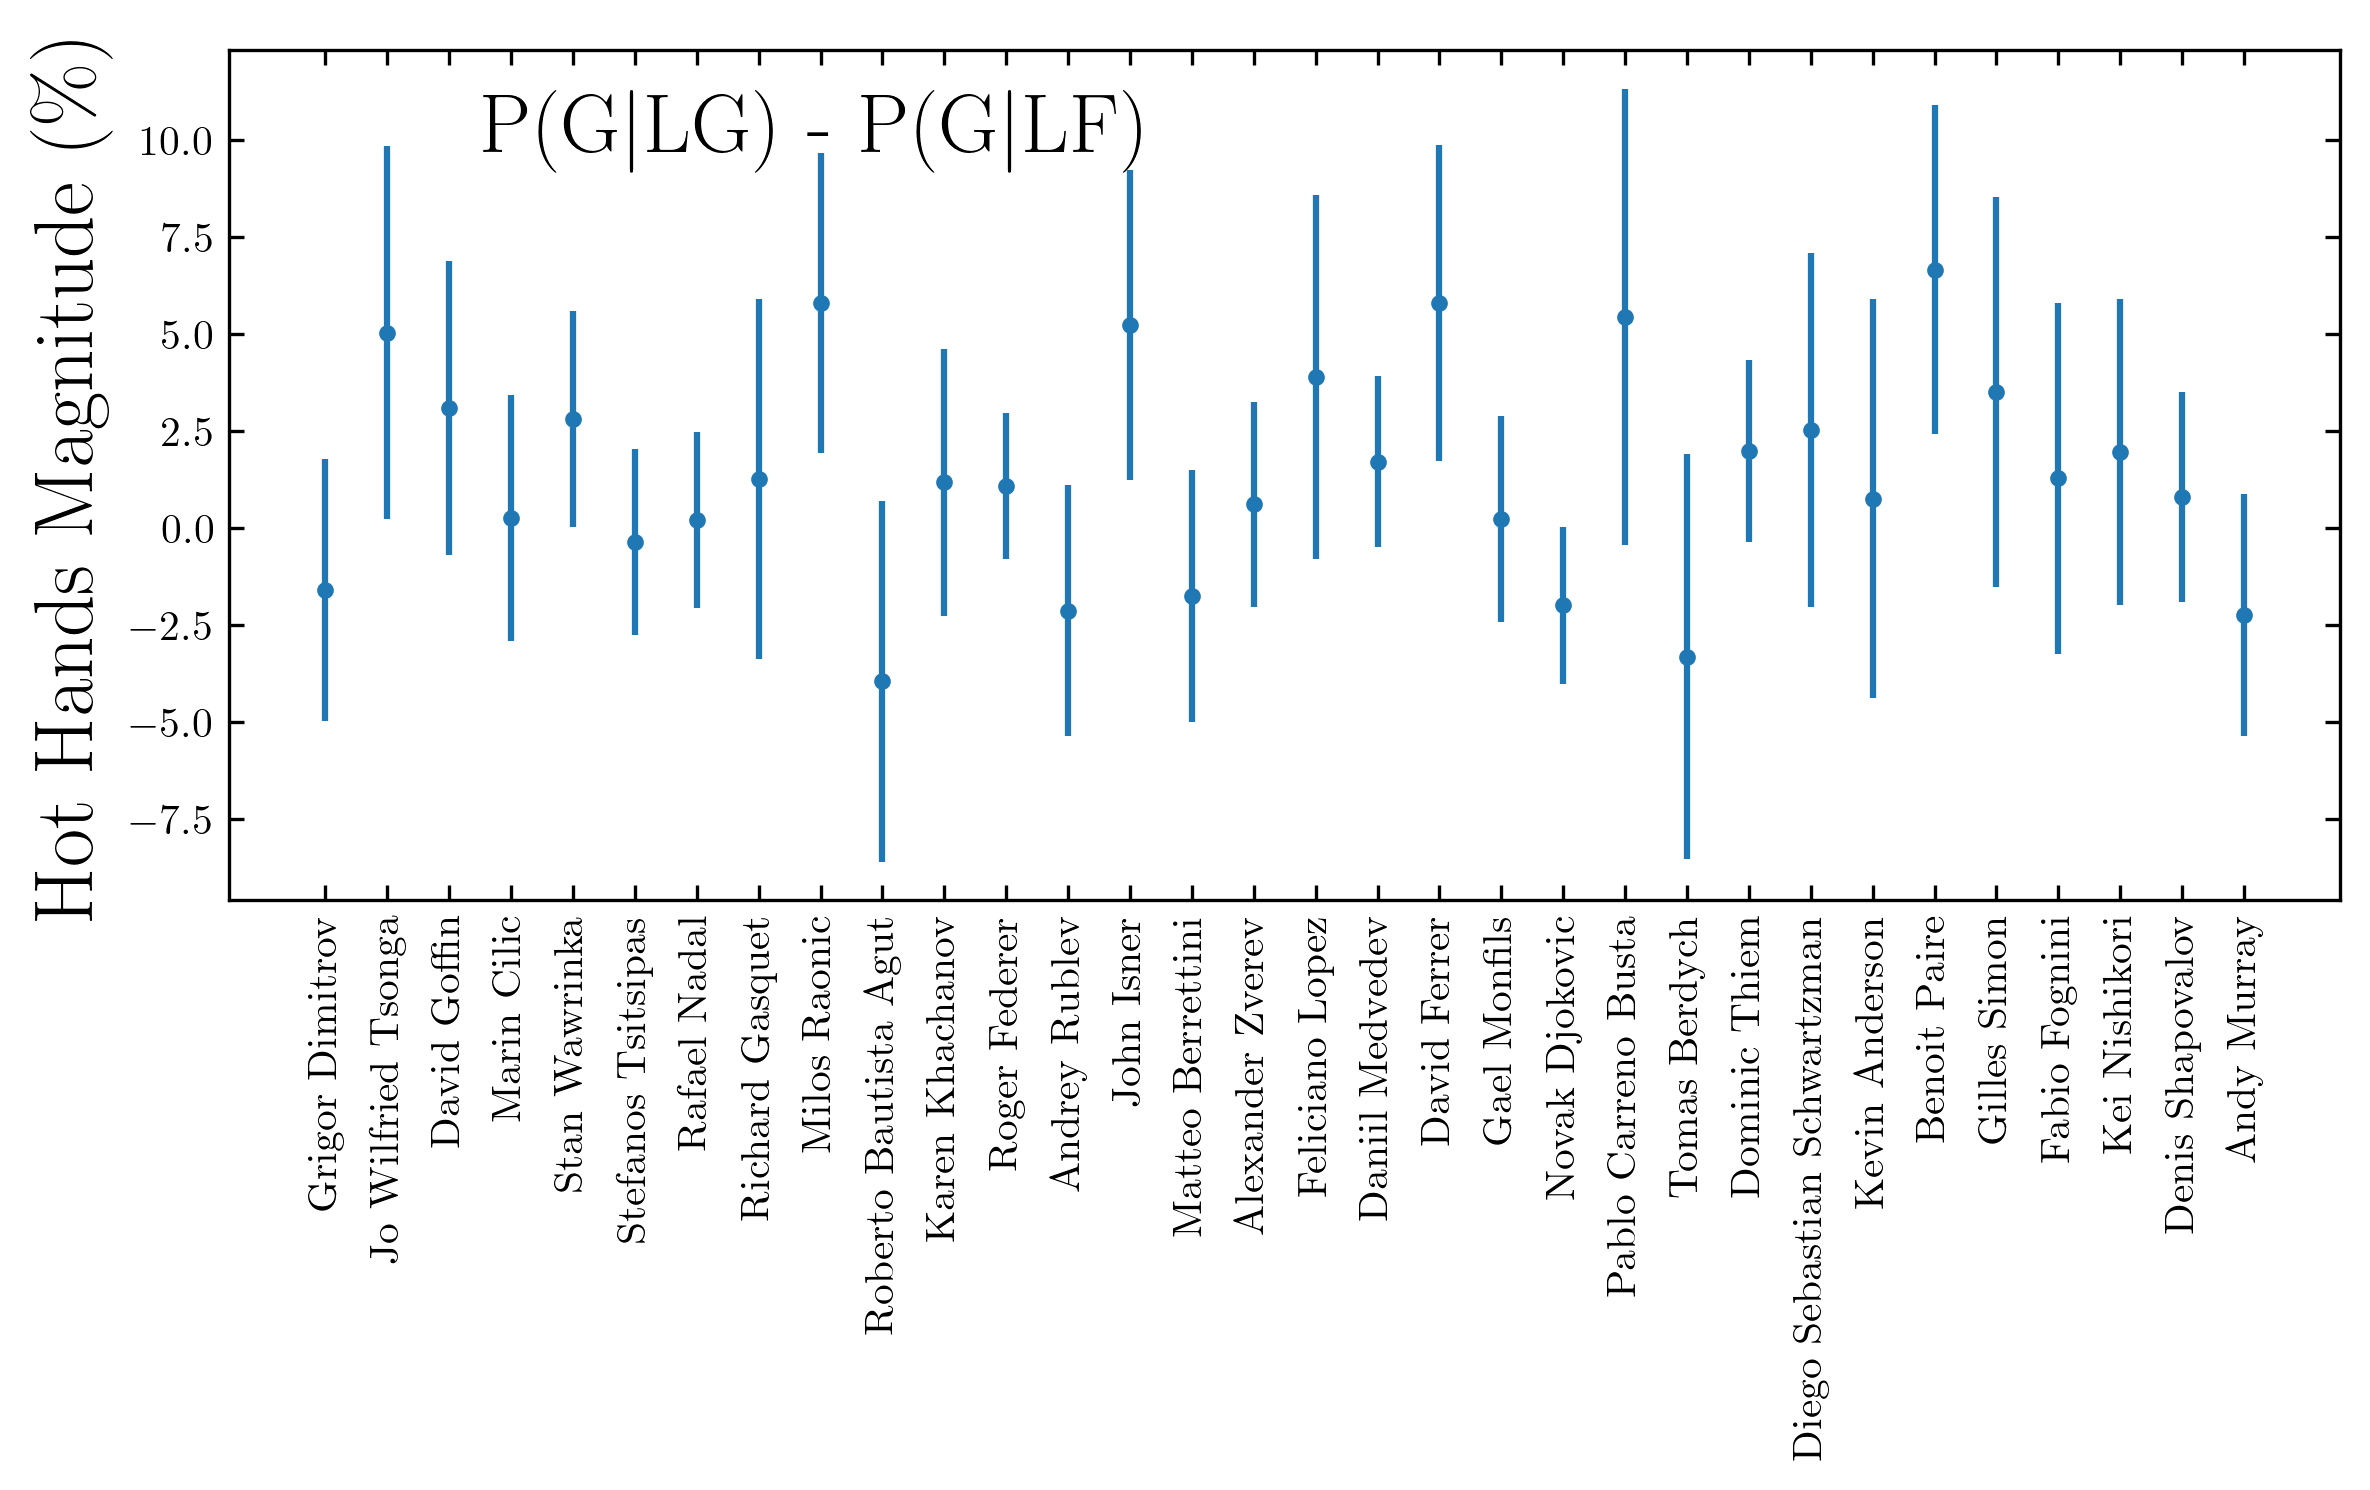

In [68]:
import matplotlib.pyplot as plt
import os
if os.path.exists('/home/gmbrandt/Documents/papers/mesa.mplstyle'):
    plt.style.use('/home/gmbrandt/Documents/papers/mesa.mplstyle')

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('P(G$\mid$LF) and P(G$\mid$LG) separately')
ax.errorbar(fpstats['player_id'], fpstats['pglf'], yerr=fpstats['e_pglf'], marker='o', 
                 markersize=3, label="P(G$\mid$LF)", ls='none')
ax.errorbar(fpstats['player_id'], fpstats['pglg'], yerr=fpstats['e_pglg'], marker='o', 
                 markersize=3, label="P(G$\mid$LG)", ls='none')
ax.set_ylabel('Probability')
ax.set_xticks([])
ax.legend(loc='best', fontsize=20, )

plt.tight_layout()


fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(fpstats['player_id'], 100*(fpstats['pglg'] - fpstats['pglf']), 
                 yerr=100*np.sqrt(fpstats['e_pglf']**2 + fpstats['e_pglg']**2), # have to add the errors in quadrature.
                              marker='o', 
                 markersize=3, ls='none')
ax.set_ylabel('Hot Hands Magnitude (\%)', fontsize=20)
ax.annotate('P(G$\mid$LG) - P(G$\mid$LF)', xy=(0.12, 0.88), xycoords='axes fraction', fontsize=20)
labels = fpstats['player_id'].data
ax.set_xticklabels(labels, rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.minorticks_off()
plt.tight_layout()
plt.savefig('Hot_hands_all_players.png', dpi=600)
plt.show()

In [9]:
def boostrap_estimate_conditional_probabilities(player_serve_data, num_resamples=1000):
    num_sets = len(player_serve_data)
    indices = np.arange(num_sets)
    statistics = []
    for i in range(num_resamples):
        this_sample = np.random.choice(indices, size=len(indices), replace=True)
        player_serve_data_sample = [player_serve_data[i] for i in this_sample]
        result = estimate_conditional_probability(player_serve_data_sample)
        statistics.append(result)
    return vstack(statistics)
    # now we have resampled posterior statistics, for this player, for every conditional probability.

## Let's show our posterior estimate for a couple players. Let's look at John Isner, who has a whopping first serve, that is known to sometimes go cold. So maybe he is the best case of a player that runs hot -- lets see.

In [59]:
resampled_statsji = boostrap_estimate_conditional_probabilities(data['John Isner'], num_resamples=2000)

In [60]:
num_samples = 0
for i in data['John Isner']:
    num_samples += len(i) - 1 # num of two-tuple sequences
print(f'we are pushing the limits of bootstrap resampling here, by using 2000 samples for Johns {num_samples} samples')

we are pushing the limits of bootstrap resampling here, by using 2000 samples for Johns 2284 samples


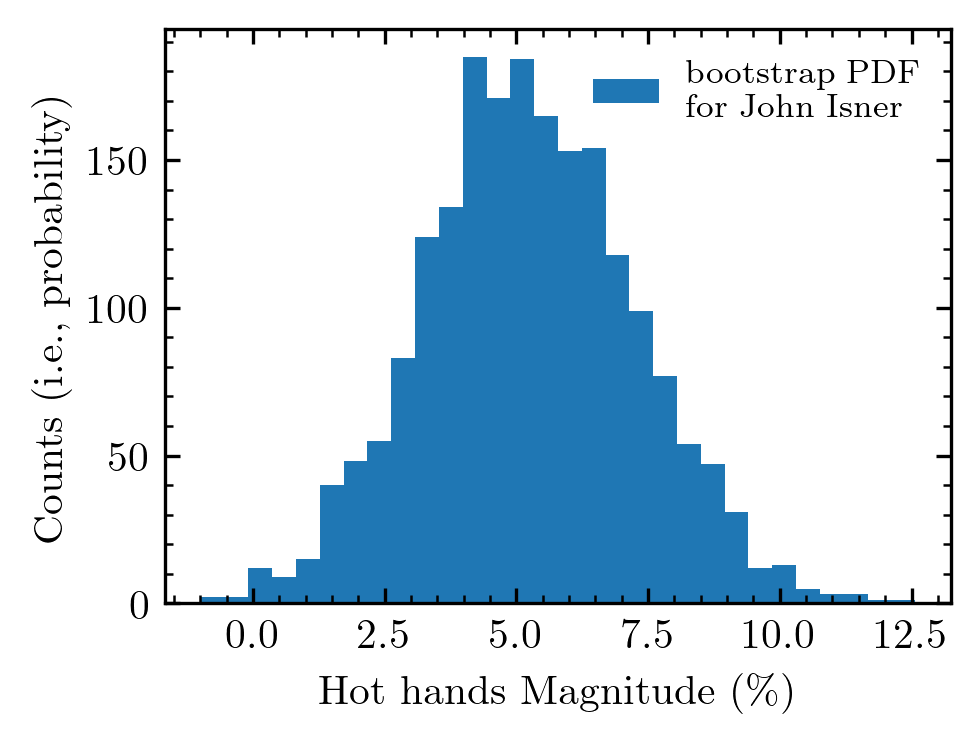

In [67]:
plt.figure()
counts = plt.hist(100*(resampled_statsji['pglg'] - resampled_statsji['pglf']), bins=30, density=False, label='bootstrap PDF \n for John Isner')[0]
plt.legend(loc='best')
plt.xlabel('Hot hands Magnitude (\%)')
plt.ylabel('Counts (i.e., probability)')
plt.savefig('hot_hands_JI.png', dpi=600)
plt.show()

## This shows, with about 2 sigma confidence** (so a modest evidence in favor, if you take this at face-value) that John Isner does have a hot hands effect. He is, on average, about 5% more likely to  make his first serve if his previous first serve went in.

** disclaimer on this quoted significance a little further down.
This should especially be taken with a large grain of salt because we used 2000 bootstrap resamples, but we only have 2300 serves on record for Isner.

## What about Roger Federer?

In [13]:
resampled_stats = boostrap_estimate_conditional_probabilities(data['Roger Federer'], num_resamples=3000)

In [14]:
num_samples = 0
for i in data['Roger Federer']:
    num_samples += len(i) - 1 # num of two-tuple sequences
print(f'we are pushing the limits of bootstrap resampling here, by using 3000 samples for RFs {num_samples} samples')

we are pushing the limits of bootstrap resampling here, by using 3000 samples for RFs 8356 samples


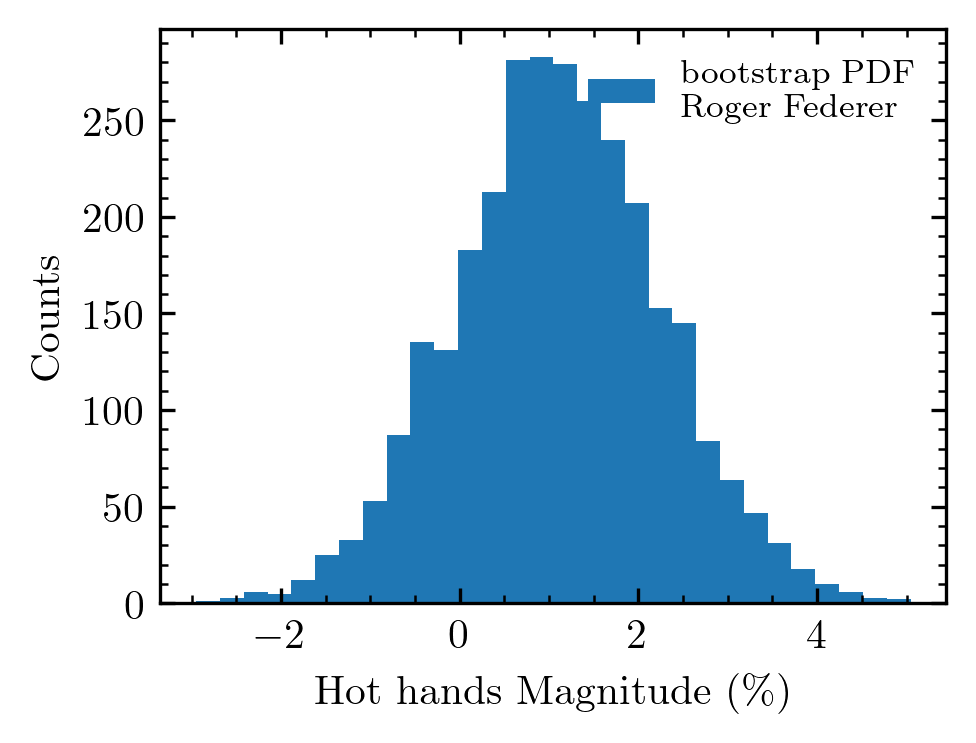

In [66]:
plt.figure()
counts = plt.hist(100*(resampled_stats['pglg'] - resampled_stats['pglf']), bins=30, density=False, label='bootstrap PDF \n Roger Federer')[0]
plt.legend(loc='best')
plt.xlabel('Hot hands Magnitude (\%)')
plt.ylabel('Counts')
plt.savefig('hot_hands_RF.png', dpi=600)
plt.show()

## This shows that Roger Federer has basically no hot-hands effect. But the converse is true too: he is just as likely to make his first serve regardless of whether his last one went in or not. So, in other words, Roger is practically unaffected by missing his previous serve. He has nerves of steel. And this result is more robust, because we have 8000 serves on record for Roger.

## Well, even John Isner has nerves of steel -- after all, these are all pros. And a cold/hot hands penalty of only 5% is amazingly small.

## The other three players that showed evidence for hot hands: Milos Raonic, David Ferrer, and Benoit Paire. All three of these players have roughly a 5% added chance of getting their first serve in if they made the previous first serve in as well.

### ** A note of caution here, following up on the John Isner "2 sigma" significant hot-hands effect; we identified 4 players with a 95% significant hot hands effect. However, just from random chance, we would expect that a sample of 33 players would have about 2 players, by random chance purely, with a 95% "significant" hot hands effect. So although it is potentially interesting that John Isner et al. have mild evidence for a hot hands effect, this is likely just a statistical likely occurance by random chance alone. 

### And in general, the evidence for a hot hands effect across the board is only mild, in general. Here we arrive at the "mild" evidence quoted in the title of the article -- *most* the players are biased above 0%..., but not by much. Doing the detailed weighted average yields the following.

In [16]:
hot_hands_effect = 100*(fpstats['pglg'] - fpstats['pglf'])
hot_hands_errors = 100*np.sqrt(fpstats['e_pglf']**2 + fpstats['e_pglg']**2)
# average the effects together with the standard inverse-variance weights:
avg = np.sum(hot_hands_effect * 1/hot_hands_errors**2 / np.sum(1/hot_hands_errors**2))
err = np.sqrt(1/np.sum(1/hot_hands_errors**2))
print(f'The average hot hands effect is {avg:.2f}% +- {err:.2f}%, only above 0 at the level of {(avg/err):.2f} Gaussian sigma.')

The average hot hands effect is 0.91% +- 0.56%, only above 0 at the level of 1.63 Gaussian sigma.


In [17]:
from scipy.stats import norm
snr = (avg/err)
survival = norm.sf(snr)*2
print(f'The odds are {int(1/survival)}:1 in favor of the hot hands effect existing.')

The odds are 9:1 in favor of the hot hands effect existing.


## So the data favors the existence of a hot hands effect, with first-serves in tennis, but the odds are only in its favor by about 9-to-1. In astrophysics, this is not nearly strong enough to be a "firm" detection. (We typically count a firm detection at 4 sigma (15,000 to 1 odds) or 5 sigma (1.7 million to 1 odds). But 9-to-1 is still 9-to-1 odds in favor. And so we arrive at the title of this article:
## I bet you 9:1 that your last serve matters. 

## Or, if you are a tennis pro reading this: if your opponent missed their first serve last point, there is (probably) a 1% higher chance they miss it this service as well. Take that for what it's worth.

Afternote: I really wished I could have done this same analysis for high school or college players. I imagine that the cold hands effect would be much more eccentuated, just because the players are not yet trained as well in staying calm. But alas, finding a source of tabulated highschool tennis serves, tens of thousands of them for the same player, is difficult.

As well, this same analysis might be more difficult on high school players for the following reason. A highschooler is not a professional -- they do not spend most of their time playing tennis, meaning there is by-definition, substantially less data on them. A given high school player will only play 30 matches a season, and their play will improve drastically as they improve year-to-year, possibly making it unreasonable to "bin" one player's consecutive years (I.e., some highschool player Bob, as a sophomore, might be a very different player as a senior). So although the hot hands effect might be larger for high school players, you will have less data on one player and so the signal will be harder to differentiate from the noise. One clever avenue could be to collect thousands of matches across the US, and bin players by their average first serve percentage. Plus, highschool players who play in USTA matches in the offseason of the scholastic tennis season would have more matches per year. There are various tricks one could play here with the data.

If you have such a dataset, I encourage you to contact me, or run this analysis on it. The framework is all here.